In [1]:
import os
import math
import random
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.animation import FuncAnimation
from scipy.stats import truncnorm
from scipy import ndimage
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator
from scipy import signal
from numpy.random import standard_normal
from numpy import isrealobj
import warnings
warnings.filterwarnings('ignore')

In [2]:
#get_distanceToEdge function
def get_distanceToEdge(plate):
    new = 1-plate
    distanceToEdge = ndimage.distance_transform_edt(new) * 250
    return distanceToEdge

In [3]:
#get_SeedingCenter function
def get_SeedingCenter(plaintext_binary, spacing):
    (plaintext_length, num_bit) = plaintext_binary.shape
    num_seeding = np.sum(np.sum(plaintext_binary, axis = 0))
    R = (num_bit - 1)/2 * spacing
    xcenter = np.linspace(-R, R, num_bit)
    
    if plaintext_length == 1:
        ycenter = np.array([0])
    
    else:
        ycenter = np.linspace(10, -10, plaintext_length)
    
    center = np.zeros((num_seeding, 2))
    idx = 0
    for i in range(num_bit):
        for j in range(plaintext_length):
            if plaintext_binary[j, i] == 1:
                center[idx, 0] = xcenter[i]
                center[idx, 1] = ycenter[j]
                idx += 1
                
    return center


In [4]:
#get_meshelements function
def get_meshelements(xx, yy, center, radius):
    idx_list = np.zeros(xx.shape)
    for i in range(np.size(center, 0)):
        x0 = center[i, 0]
        y0 = center[i, 1]
        idx = np.array(((xx-x0)**2 + (yy-y0)**2 - radius**2) < 0)
        idx = np.where(idx == True, 1, 0)
        if i == 0:
            idx_list = idx
        else:
            idx_list = idx_list + idx
    return idx_list

In [5]:
# get_Noise function
def get_Noise(option, length):
    # -------------------------------------------------------------------------
    #   SEEDING NOISE
    #       1: uniform;                  2: Gaussian,large var;
    #       3: Gaussian, small var;      4: no noise
    # -------------------------------------------------------------------------

    # random.seed(20349) # use if need to fix seeding
    
    if option == 1:
        sigma = 0.5
        mu = 0.5
        lower = mu-sigma
        upper = mu+sigma
        normal_trunc = truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        values = normal_trunc.rvs(size = length)
        
    elif option == 2:
        sigma = 0.25
        mu = 0.5
        lower = mu-sigma
        upper = mu+sigma
        normal_trunc = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        values = normal_trunc.rvs(size = length)
        
    elif option == 3:
        sigma = 0.1
        mu = 0.5
        lower = mu-sigma
        upper = mu+sigma
        normal_trunc = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        values = normal_trunc.rvs(size = length)
        
    elif option == 4:
        values = np.ones(length)* 0.5
        
    return values

In [6]:
#get_Plaintext function
def get_Plaintext(ID, num_replicate):
    plaintext = math.floor(ID / num_replicate)
    if ID % num_replicate != 0:
        plaintext += 1
    return plaintext

In [7]:
#get_Plate function
def get_Plate(opt, pixelSize, plateDiameter, x, y, scale):
# -------------------------------------------------------------------------
#   PLATE SHAPE:
#       1: circular       2:square        3:diamond
#       4:triangle        5:rectangle     6:semisphere
#
#   SCALE:
#       shrink the plate area by scale       
# -------------------------------------------------------------------------
    plate_bool = True
    plate = 1

    if opt == 11:
        r = 225
        plate_bool = (np.sqrt(x**2 + y**2)) >= r

    elif opt == 1:
        r = 254/scale
        plate_bool = (np.sqrt(x**2 + y**2)) >= r

    elif opt == 2:
        l = 450/scale
        a = abs(x) < (l/2)
        b = abs(y) < (l/2)
        plate_bool = ~(a & b)

    elif opt == 3:
        l = 450 / scale
        k = math.floor(l / math.sqrt(2))
        a = (x < y + k)
        b = (x < -y + k)
        c = (x > -y - k)
        d = (x > y - k)
        plate_bool = ~(a & b & c & d)

    elif opt == 4:
        R = 684 / scale
        h = R / 2 / math.sqrt(3)
        k = R / math.sqrt(3)
        a = (x < (y + k) / math.sqrt(3))
        b = (x > -(y + k) / math.sqrt(3))
        c = (y < h)
        plate_bool = ~(a & b & c)

    elif opt == 5:
        half_width = 0.4 * plateDiameter / pixelSize / 2
        half_length = 1 * plateDiameter / pixelSize / 2
        a = abs(x) < half_width
        b = abs(y) < half_length
        plate_bool = ~(a & b)

    elif opt == 6:
        yy = y - 225 / 3
        a = (y < 225 / 3)
        b = np.sqrt(x**2 + yy**2) * pixelSize >= plateDiameter / 2
        c = (y < 225 * 2 / 3)
        plate_bool = ~(~(a & b) & c)
        
    plate = np.where(plate_bool == True, 1, 0)

    return plate


In [8]:
#
def de2bi(d, n):
    d = np.array(d)
    power = 2**np.arange(n)
    d = d * np.ones((1,n))
    b = np.floor((d%(2*power))/power)
    return b

In [9]:
#plaintext2binary function
def plaintext2binary(plaintext, bit):
    plaintext_binary = np.flip(de2bi(plaintext, bit))
    plaintext_binary = plaintext_binary.astype(int)
    return plaintext_binary

In [10]:
def awgn(s, snr):
    random.seed(12945)
    gamma = 10**(snr/10)
    if s.ndim == 1:
        P = np.sum(abs(s)**2)/len(s)
    else:
        P = np.sum(np.sum(abs(s)**2))/len(s)
    N0 = P/gamma
    if isrealobj(s):
        n = np.sqrt(N0/2)*standard_normal(s.shape)
    else:
        n = np.sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape)) 
    r = s + n
    return r

In [11]:
#makeKernel function
def makeKernel(plateDiameter, gridSize, positiveRadius, postitiveExponent, positiveBenefit, negativeRadius, negativeExponent, maximumRepulsionRadius, pixelSize, kernelopt):
    
    # make the dispersal kernel
    # positiveRadius    - d1
    # negativeRadius    - d2
    # postitiveExponent - h1: inf
    # negativeExponent  - h2: inf
    # positiveBenefit   - b
    # rKernel           - d
    # vKernel           - f(d), formula 4 in Xavier's
    
    rKernel = np.linspace(0, plateDiameter/2, gridSize)
    vKernel = positiveBenefit * 2**(-(rKernel/positiveRadius)**postitiveExponent) - 2**(-(rKernel/negativeRadius)**negativeExponent)
    
    filterSize = math.floor(maximumRepulsionRadius * 2 / pixelSize)
    if (filterSize % 2) == 0:
        filterSize += 1
    
    xFilter = np.array([i for i in range(filterSize)]) - (filterSize/2) + 0.5
    yFilter = xFilter
    (xFilter, yFilter) = np.meshgrid(xFilter, yFilter)
    rFilter = np.sqrt(xFilter**2 + yFilter**2) * pixelSize
    
    filterKernel = PchipInterpolator(rKernel, vKernel)(rFilter) 
    
    # Add noise to kernel
    if kernelopt == 2:
        indices = np.where(filterKernel > 0)
        a = filterKernel[filterKernel > 0]
        snr = 10
        filterKernel[indices] = awgn(a, snr)
        
    
    elif kernelopt == 3:
        indices = np.where(filterKernel > 0)
        a = filterKernel[filterKernel > 0]
        snr = 3.5
        filterKernel[indices] = awgn(a, snr)
        
    
    elif kernelopt == 4:
        indices = np.where(filterKernel > 0)
        a = filterKernel[filterKernel > 0]
        snr = 2
        filterKernel[indices] = awgn(a, snr)
    return filterKernel
    

In [12]:
#crop_Img function
def crop_Img(IM, x, y, scale, BACKGROUND):
    idx = np.sqrt(x**2 + y**2) > (450/3/scale)
    cropped_Img = IM;
    
    if BACKGROUND == 0: # don't include the plate
        cropped_Img[idx] = 0
    else:# include the plate
        cropped_Img[idx] = 1
        
    return cropped_Img


In [13]:
#encoding function
def encoding(ID, path, r0, spacing, seeding_noise, kernel_noise, plate_shape, scale, text_bit, num_replicate, IFCROP):
    
    # create paths for storing the outputs
    parent_dir = os.getcwd()
    path_text = os.path.join(parent_dir, "plaintext/")
    path_initial = os.path.join(parent_dir, "initial/")
    path_final = os.path.join(parent_dir, "final/")
    if not os.path.exists(path_text):os.mkdir(path_text)
    if not os.path.exists(path_initial):os.mkdir(path_initial)
    if not os.path.exists(path_final):os.mkdir(path_final)
    if IFCROP == 1:
        path_cropped = os.path.join(parent_dir, "cropped/")
        if not os.path.exists(path_cropped):os.mkdir(path_cropped)
    
    #--------------------------------------------------------------------------
    #PARAMETERS
    
    d1d2 = 0.4 #d1/d2
    positiveBenefit = 6.5 #b
    positiveRadius = 1000 #d1
    negativeRadius = positiveRadius/d1d2
    positiveExponent = 2000 #h1
    negativeExponent = positiveExponent #h2
    plateRadius = negativeRadius
    plateExponent = 2000
    pixelSize = 200 #resolution, um per pixel
    
    if IFCROP == 0:
        plateDiameter = pixelSize*450 #Petri dish diameter, um
    elif IFCROP == 1:
        plateDiameter = pixelSize * 790
    
    nt = 3000 # total time step
    bw = matplotlib.colors.ListedColormap(["white", "black"])
    
    #--------------------------------------------------------------------------
    #GROWTH DOMAIN
    
    # define grid
    maximumRepulsionRadius = negativeRadius*(math.log2(10**1.2)**(1/negativeExponent))
    gridSize = int(plateDiameter/pixelSize)
    if (gridSize % 2) == 0:
        gridSize += 1
    
    # define plate
    x = (np.array([i for i in range(gridSize)]) - (gridSize/2)) + 0.5
    y = x
    (x, y) = np.meshgrid(x, y)
    plate = get_Plate(plate_shape, pixelSize, plateDiameter, x,y,scale)
    
    # save the image of the plate
    #plate_save = plate == 0
    #figname = path_initial + "Shape_ID_" + str(ID) + ".jpg"
    #plt.imsave(figname, plate_save, cmap = bw)
    
    #get distance of plate center to edge
    r = np.sqrt(x**2 + y**2)*pixelSize
    distanceToEdge = get_distanceToEdge(plate)
    
    #--------------------------------------------------------------------------
    #PLAINTEXT
    plaintext = get_Plaintext(ID, num_replicate) #decimal
    plaintext_binary = plaintext2binary(plaintext, text_bit)
    
    #save the plaintext
    textname = path_text + "Plaintext_ID_" + str(ID) + ".txt"
    fileID = open(textname, "w")
    fileID.write(str(plaintext))
    fileID.close()
    
    #--------------------------------------------------------------------------
    #INITIAL PATTERN
    
    center = get_SeedingCenter(plaintext_binary, spacing)
    
    #configuration, 0 -> no seeding, 1 -> spot seeding
    config = get_meshelements(x, y, center, r0)
    
    #add noise
    noise_length = int(np.sum(np.sum(config, axis = 0)))
    values = get_Noise(seeding_noise, noise_length)
    
    colony = np.zeros((gridSize, gridSize))
    #plot seeding configuration
    #colony_copy = plate + colony
    #colony_copy[config == 1] = 1
    #figname = path_initial + "Config_ID_" + str(ID) + ".jpg"
    #plt.imsave(figname, colony_copy, cmap="gray")
    
    #initiate colony 
    col_transpose = np.transpose(colony)
    con_transpose = np.transpose(config)
    col_transpose[con_transpose == 1] = values
    colony = np.transpose(col_transpose)
    
    #plot initial pattern
    figname1 = path_initial + "IImg_ID_" + str(ID) + ".jpg"
    # plt.imshow(colony, "gray")
    plt.imsave(figname1, colony, cmap="gray")
    
    #--------------------------------------------------------------------------
    #GROWTH

    colonyTracks = colony
    iterationResidual = np.empty((nt, 1)) 
    iterationResidual[:] = np.NaN
    
    plt.figure()
    for i in range(nt):
        colonyOld = colony
        filterKernel = makeKernel(plateDiameter, gridSize, positiveRadius, positiveExponent, 
                                  positiveBenefit, negativeRadius, negativeExponent, maximumRepulsionRadius, 
                                  pixelSize, kernel_noise)
        growth = signal.correlate2d(colony, filterKernel, "same") 
        
        #subtract plate influence
        plateInfluence = -2**(-(distanceToEdge/plateRadius)**(plateExponent)) * 1000
        plateInfluence[plate == 1] = 0
        growth = growth + plateInfluence
        
        #update colony
        growth[plate == 1] = 0
        colony = colony + growth
        colony[colony<0] = 0
        mVal = 8
        colony[colony > mVal] = mVal
        colonyTracks[colony > 0.1] = 1
        
        #plot colony
        IM = colonyTracks*0 + colony + plate*5
        IM = IM == 0
        #if i % 10 == 0:
        #    plt.imshow(IM, bw)
        #    figname = path_final + str(ID) + "_" + str(i) + ".jpg"
        #    plt.imsave(figname, IM, cmap=bw)
        
        #terminate the simulation if colony stops growing     
        iterationResidual[i] = len(colony[np.where(colonyOld != colony)])
        if int(iterationResidual[i]) == 0:
            break
    
    #save final pattern
    figname2 = path_final + "FImg_ID_" + str(ID) + ".jpg"
    plt.imsave(figname2, IM, cmap=bw)
    
    #save cropped pattern center
    if IFCROP == 1:
        cropped_Img = crop_Img(IM, x, y, scale, 0) 
        cropped_Img_copy = crop_Img(IM, x, y, scale, 1)
        a = int((plateDiameter/pixelSize-450/scale)/2)
        b = int(a + 450/scale)
        cropped_Img = cropped_Img[a:b, a:b] 
        cropped_Img_copy = cropped_Img_copy[a:b, a:b]
        cropped_Img_copy = cropped_Img_copy == 0
        
        plt.figure()
        plt.imshow(cropped_Img, bw)
        figname3 = path_cropped + "Cropped_ID_" + str(ID) + ".jpg"
        plt.imsave(figname3, cropped_Img, cmap=bw)
        figname4 = path_cropped + "Cropped_WBG_ID_" + str(ID) + ".jpg"
        plt.imsave(figname4, cropped_Img_copy, cmap=bw)

done


<Figure size 432x288 with 0 Axes>

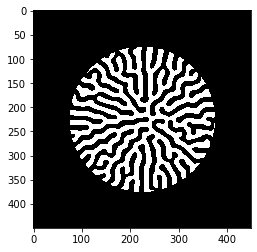

In [14]:
### Main ### 
 
# Set up the simulation parameter
#   SEEDING NOISE
#       Gaussian distribution, mean 0.5, deviation:
#       1 -- 0.5      2 -- 0.25      3 -- 0.1      4 -- no noise
#
#   GROWTH KERNEL NOISE
#       1: no white noise;       2: low white noise;
#       3: medium white noise;   4: high white noise
#
#   PLATE SHAPE
#      Default -- 
#               11: circular plate
#      Encryption --
#               1: circle;  2:square;   3:rectangle;    
#               4:diamond;  5:triangle 
# 
#   TEXT LENGTH
#       2, 4, 6 or 8 bits
#
#   IFCROP
#       TRUE - for encryption only, otherwise FALSE

r0 = 5
spacing = 10 #10, 20, 30
seeding_noise = 1
kernel_noise = 1 #1-no, 2-low, 4-high
plate_shape = 1
scale = 1  # Always <=1
text_bit = 4
num_replicate = 1
IFCROP = 0

if plate_shape != 11:IFCROP = 1
else:IFCROP = 0

path = os.getcwd()

# Simulation
ID = 1 # Change this to change which character to encode. For example, let 0-9, A-E correspond to ID=1-15. If we want to generate a pattern for "B", then we let ID = 12.

# Save the modeling parameters once
filename = r"Simulation_Parameters.txt"
lines = ["r0: " + str(r0), "spacing: " + str(spacing), "seeding: " +  str(seeding_noise), "kernel: " + str(kernel_noise), "shape: " + str(plate_shape), "scale: " + str(scale), "bit: " + str(text_bit), "crop: " + str(IFCROP)]
with open(filename, "w") as fileID:
    fileID.write("\n".join(lines))
fileID.close()

# Run the patterning simulation
encoding(ID, path, r0, spacing, seeding_noise, kernel_noise, plate_shape, scale, text_bit, num_replicate, IFCROP)

print("done")        
